In [20]:
# Import libraries here
import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [21]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in <cityName>, less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # split lat-lon column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract newColumnName
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop feature with high null count
    df.drop(columns=["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", "expenses"], inplace=True)
    
    # Drop low- and high- categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)
    
    # Drop columns with multi-colinerlity
    #df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

df = wrangle("data/mexico-city-real-estate-1.csv")

In [22]:
print(df.shape)
df.info()

(1100, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 4623
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1100 non-null   int64  
 1   price_aprox_usd        1100 non-null   float64
 2   surface_covered_in_m2  1100 non-null   float64
 3   lat                    1031 non-null   float64
 4   lon                    1031 non-null   float64
 5   borough                1100 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 60.2+ KB


In [23]:
files = sorted(glob("data/mexico-city-real-estate-*.csv"))
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

In [24]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5472 non-null   int64  
 1   price_aprox_usd        5472 non-null   float64
 2   surface_covered_in_m2  5472 non-null   float64
 3   lat                    5139 non-null   float64
 4   lon                    5139 non-null   float64
 5   borough                5472 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 256.6+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,1,63223.78,88.0,19.516777,-99.160149,Gustavo A. Madero
1,2,25289.51,48.0,19.466724,-99.131614,Gustavo A. Madero
2,18,89250.90,90.0,19.383327,-99.152712,Benito Juárez
3,20,39887.51,60.0,19.388280,-99.195529,Álvaro Obregón
4,21,42475.37,80.0,19.454582,-99.145651,Cuauhtémoc


Text(0.5, 1.0, 'Distribution of Apartment Prices')

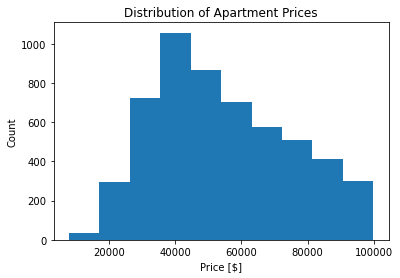

In [25]:
# Build histogram
plt.hist(df["price_aprox_usd"])

# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")


# Add title
plt.title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

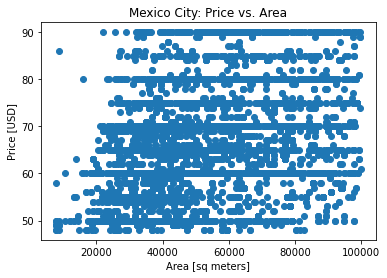

In [26]:
# Build scatter plot
plt.scatter(x=df["price_aprox_usd"], y= df["surface_covered_in_m2"])

# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")


# Add title
plt.title("Mexico City: Price vs. Area")


In [27]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)


fig.update_layout(mapbox_style="open-street-map")

fig.show()


In [28]:
# Split data into feature matrix `X_train` and target vector `y_train`.

target = "price_aprox_usd"
feature = ["surface_covered_in_m2","lat","lon","borough"]
X_train = df[feature]
y_train = df[target]

In [29]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54281.26775036551
Baseline MAE: 17344.949450240165


In [30]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

# Build Model
model =  make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

(5472, 18)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [31]:
X_test = pd.read_csv("data/mexico-city-test-features.csv",index_col=[0]).reset_index(drop=True)
print(X_test.info())
X_test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [32]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred[:4]

0    53235.368533
1    53402.242338
2    34490.589664
3    53181.241242
dtype: float64

In [36]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [37]:
#Communicate Results

coefficients = model.named_steps["ridge"].intercept_
features = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp


surface_covered_in_m2            -213145.040299
lat                              -213145.040299
lon                              -213145.040299
borough_Gustavo A. Madero        -213145.040299
borough_Benito Juárez            -213145.040299
borough_Álvaro Obregón           -213145.040299
borough_Cuauhtémoc               -213145.040299
borough_Coyoacán                 -213145.040299
borough_Venustiano Carranza      -213145.040299
borough_Iztacalco                -213145.040299
borough_Tlalpan                  -213145.040299
borough_Azcapotzalco             -213145.040299
borough_Iztapalapa               -213145.040299
borough_Miguel Hidalgo           -213145.040299
borough_Tláhuac                  -213145.040299
borough_Xochimilco               -213145.040299
borough_La Magdalena Contreras   -213145.040299
borough_Cuajimalpa de Morelos    -213145.040299
dtype: float64

In [34]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [35]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=90, min=48), FloatSlider(value=19.4551822745…